## Laboratorium 8.2


## Przepływ optyczny i śledzenie obiektów

### Wprowadzenie

Metodę przepływu optycznego (między innymi) można stosować również do śledzenia obiektów. Zazwyczaj wykorzystuje się w tym celu metody rzadkie połączone ze znanymi już nam metodami detekcji punktów zainteresowania. Procedura przebiega podobnie jak w przypadku gęstego przepływu (tzn. operujemy na parze klatek w skali szarości, znajdujemy wektory przesunięć), z tą różnicą że obliczanie przepływu zachodzi wyłącznie dla interesujących nas punktów - a zatem musimy znać ich położenia, aby zainicjować proces. Można sobie wyobrazić różne sposoby zlokalizowania punktów kluczowych, w zależności od konkretnego zastosowania i założeń: być może np. pipeline do przetwarzania rozpoczyna się od detekcji obiektów, a może z góry wiemy, gdzie obiekty się początkowo znajdują.

W OpenCV podstawową metodą do obliczania przepływu dla zbioru punktów jest metoda Lucasa-Kanade, zaimplementowana w funkcji [`cv2.calcOpticalFlowPyrLK`](https://docs.opencv.org/3.4/dc/d6b/group__video__track.html#ga473e4b886d0bcc6b65831eb88ed93323). Podobnie jak w metodzie Farnebacka, argument `nextPts` ustawiamy na `None` (chyba, że chcemy zainicjować rozwiązanie już znanymi położeniami punktów, ale w praktyce z reguły nie będziemy mieli takiej wygody), argumenty `status` i `err` pomijamy zupełnie. W odróżnieniu od Farnebacka, wynikiem są absolutne położenia punktów na drugiej klatce (a nie wektory przesunięć). Dodatkowo otrzymujemy też wektor `status` informujący dla każdego punktu, czy udało się go odnaleźć, oraz `err` mierzący jakąś miarę błędu wizualnego pomiędzy fragmentem obrazu zawierającym dany punkt kluczowy.

Do inicjalizacji rozwiązania można wykorzystać znane nam metody znajdowania punktów kluczowych, albo opartą o detektor Harrisa funkcję [`cv2.goodFeaturesToTrack`](https://docs.opencv.org/3.4/dd/d1a/group__imgproc__feature.html#ga1d6bb77486c8f92d79c8793ad995d541) - jest nieco prostsza w użyciu, bo na wyjściu otrzymujemy po prostu macierz `np.float32` o wymiarach $Nx1x2$ zawierającą koordynaty znalezionych punktów.

Oczywiście, śledzenie obiektów oparte o jednorazową inicjalizację jest narażone na błędy: zniknięcie lub tymczasowe zasłonięcie śledzonego obiektu, czy choćby zmiana jego wyglądu (np. wskutek pojawienia się cienia) mogą spowodować, że przepływ nie zostanie obliczony. Może być też pożądana możliwość śledzenia ciągłego z uwzględnieniem pojawiania się nowych obiektów (np. monitorowanie CCTV). W takich sytuacjach konieczne jest regularne odświeżanie inicjalizacji, tj. ponowne wykrycie interesujących obiektów. To z kolei prowadzi do kolejnego problemu: jeżeli interesuje nas cała historia ruchu danych obiektów, przy czym do pewnego momentu ich lokalizacje uzyskiwaliśmy za pomocą przepływu optycznego, a w pewnym momencie wykonaliśmy ponowną detekcję - to jak powiązać jedno z drugim, by zapewnić ciągłość lokalizacji? To zagadnienie, oraz pozostałe tematy dyskutowane w tym kontekście na wykładzie, nie będzie jednak centralne na laboratorium.

---

### Cel zadania

Celem tej listy jest (1) zapoznanie się z metodą przepływu optycznego rzadkiego do zastosowań śledzenia obiektów, oraz (2) zastosowanie tej techniki w praktyce, na przykładzie monitorowania prędkości obiektu (w metrach na sekundę). Przykładem badawczym będzie nagranie startu Wahadłowca Kosmicznego _Discovery_ (misja [STS-124](https://en.wikipedia.org/wiki/STS-124)), zarejestrowane jedną z kamer technicznych (plik `shuttle.mp4`).

Aby obliczyć prędkość, potrzebna jest znajomość drogi (w metrach) i czasu (w sekundach). Czas między klatkami obliczysz, znając liczbę klatek na sekundę, którą możesz pobrać bezpośrednio z otwartego obiektu `VideoCapture` za pomocą następującej konstrukcji:  
```python
fps = source.get(cv2.CAP_PROP_FPS)
```  
Wyznaczenie przelicznika między przestrzenią obrazu (w pikselach) a przestrzenią świata (w metrach) jest w ogólności [nieco złożonym zagadnieniem](https://docs.opencv.org/4.x/dc/dbb/tutorial_py_calibration.html); znalezienie uproszczonej alternatywy jest Twoim zadaniem.

Źródło nagrania: [_"Best of the Best" Provides New Views, Commentary of Shuttle Launches_ (NASA @ YouTube)](https://www.youtube.com/watch?v=vFwqZ4qAUkE), 29:06.5  
Nagranie o oryginalnej prędkości ~225 fps odtwarzane przy typowej prędkości 30fps wyglądałoby na spowolnione w proporcji ok. 1:7.5; zostało zatem przekodowane tak, aby osiągnąć zbieżność upływu czasu 1:1 z rzeczywistym. Możesz się o tym upewnić patrząc na _timestamp_ z prawej strony nagrania ([_jak go czytać_](https://space.stackexchange.com/a/38569)).

In [3]:
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt

### Zadanie 1

Na podstawie pierwszej klatki z materiału dokonaj kalibracji parametrów detektora cech do śledzenia (sugerowany detektor: [`cv2.goodFeaturesToTrack`](https://docs.opencv.org/3.4/dd/d1a/group__imgproc__feature.html#ga1d6bb77486c8f92d79c8793ad995d541)). Dobór tych parametrów jest kluczowy dla reszty zadania, więc zapoznaj się z ich znaczeniem i postaraj tak dobrać, by uzyskać odpowiednio dużo (10+) punktów w rejonie śledzonego obiektu.

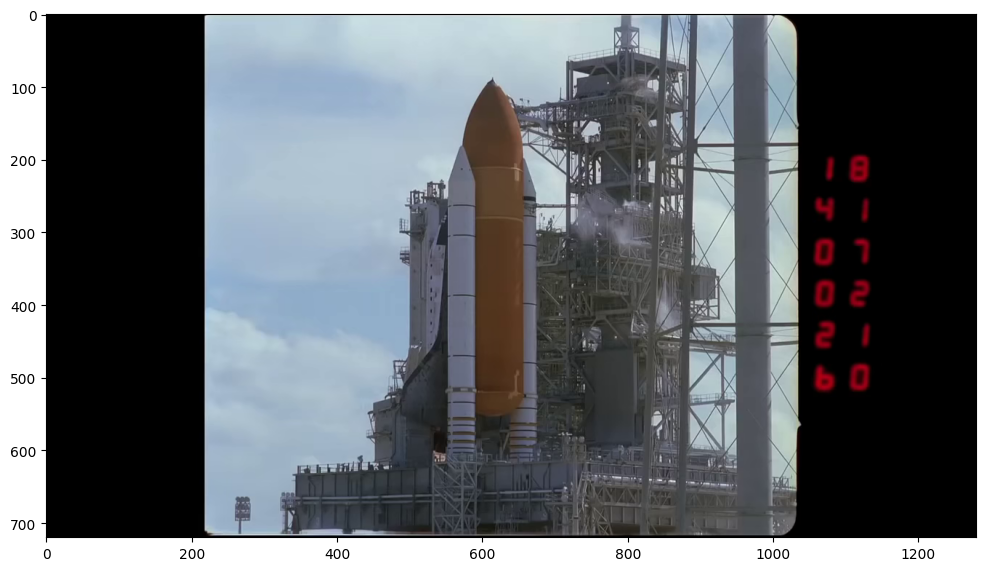

In [4]:
source = cv2.VideoCapture('shuttle.mp4')
status, frame = source.read()
source.release()
plt.subplots(1, 1, figsize=(12,12))[1].imshow(frame[..., ::-1]);

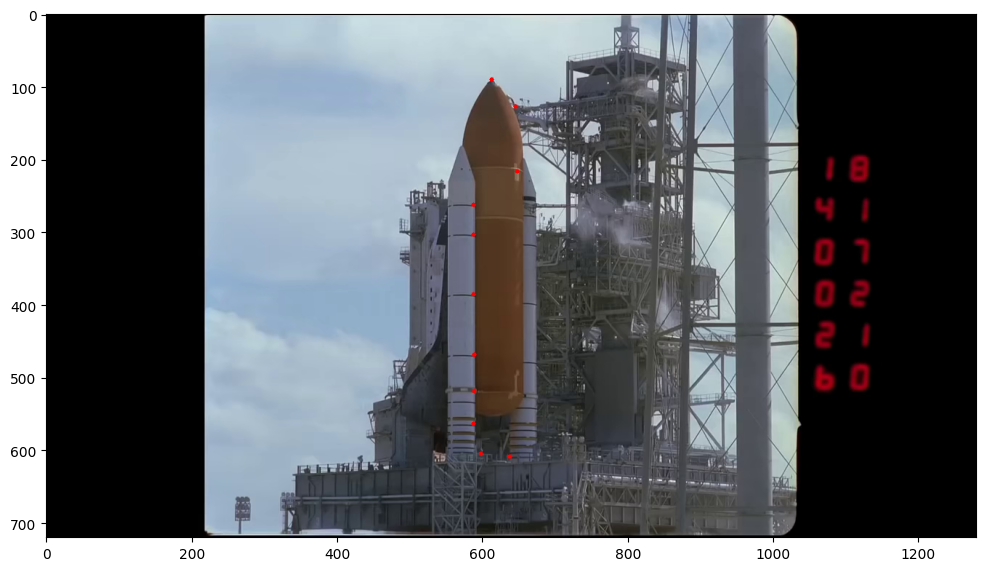

In [5]:
img = frame[..., ::-1].copy() 
gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

params = dict(maxCorners = 500,
    qualityLevel = 0.05,
    minDistance = 40,
    blockSize = 7)

h, w = gray_img.shape
mask = np.zeros_like(gray_img)
bottom = int(0.85 * h)
top = int(0 * h)
left = int(0.45 * w)
right = int(0.51 * w)
mask[top:bottom, left:right] = 255
    

corners = cv2.goodFeaturesToTrack(gray_img, mask = mask, **params)
corners = np.intp(corners)

for i in corners:
    x, y = i.ravel()
    cv2.circle(img, (x, y), 3, (255, 0, 0), -1)
plt.subplots(1, 1, figsize=(12, 12))[1].imshow(img)

if cv2.waitKey(0) & 0xff == 27:  
    cv2.destroyAllWindows() 

### Zadanie 2

Uzupełnij daną poniżej podstawową pętlę analizy wideo o śledzenie obiektów: inicjalizację i wykorzystanie przepływu optycznego do aktualizacji ich położenia. Celem jest pozyskanie pełnej trajektorii pojazdu, tak aby można było ją narysować (np. [`cv2.polylines`](https://docs.opencv.org/3.4/d6/d6e/group__imgproc__draw.html#gaa3c25f9fb764b6bef791bf034f6e26f5)) tudzież przetwarzać dalej.

Zapoznaj się dobrze z dokumentacją funkcji [`cv2.calcOpticalFlowPyrLK`](https://docs.opencv.org/3.4/dc/d6b/group__video__track.html#ga473e4b886d0bcc6b65831eb88ed93323), zwłaszcza z wartościami zwracanymi, **zwłaszcza** `status`. Upewnij się, że odpowiednio obsługujesz przypadki niepowodzenia znalezienia przepływu dla poszczególnych punktów.

Wynik zaprezentuj w postaci graficznej (narysowane trajektorie).

In [6]:
from IPython.display import display, clear_output
from PIL import Image

In [7]:
def baseLoop(source: cv2.VideoCapture):
    frame1 = None
    status, frame2 = source.read()
    frame2_gray = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)
    # corner detection params
    features_params = dict(maxCorners = 500,
                           qualityLevel = 0.01,
                           minDistance = 30,
                           blockSize = 7)
    # Lucas-Kanade params
    lk_params = dict(winSize = (21, 21),
                     maxLevel = 3,
                     criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))
    # corner detection mask
    h, w = frame2_gray.shape
    mask = np.zeros_like(frame2_gray)
    bottom = int(0.85 * h)
    top = int(0 * h)
    left = int(0.45 * w)
    right = int(0.51 * w)
    mask[top:bottom, left:right] = 255
    
    # corner detection
    p0 = cv2.goodFeaturesToTrack(frame2_gray, 
                                 mask = mask,
                                 **features_params)
    
    # matrix for drawing purposes
    drawing_fig = np.zeros_like(frame2)
    # store images and points
    imgs = []
    points = []
    statuses = []
    
    while status:
        frame1 = frame2_gray
        status, frame2 = source.read()
        if not status:
            break
        frame2_gray = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)
        
        p1, st, _ = cv2.calcOpticalFlowPyrLK(frame1, 
                                            frame2_gray, 
                                            p0, 
                                            None, 
                                            **lk_params)
        statuses.append(st.reshape(-1))
        # select good points
        good_new = p1[st == 1]
        good_old = p0[st == 1]
        
        # draw the tracks
        for _, (new, old) in enumerate(zip(good_new, good_old)):
            a, b = new.ravel()
            c, d = old.ravel()
            drawing_fig = cv2.line(drawing_fig, (int(a), int(b)), (int(c), int(d)), (0, 255, 0), 2)
            frame2 = cv2.circle(frame2, (int(a), int(b)), 5, (0, 0, 255), -1)
        img = cv2.add(frame2, drawing_fig)
        imgs.append(img)
        
        # Convert the image to RGB (OpenCV uses BGR by default)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # Convert the image to a PIL Image
        img_pil = Image.fromarray(img_rgb)
        # Display the image in the notebook
        clear_output(wait=True)
        display(img_pil)
        if cv2.waitKey(30) & 0xFF == 27:
            break
        # update points
        p0 = good_new.reshape(-1, 1, 2)
        points.append(p0)
        
    cv2.destroyAllWindows()
    source.release()   
    
    return imgs, points, statuses

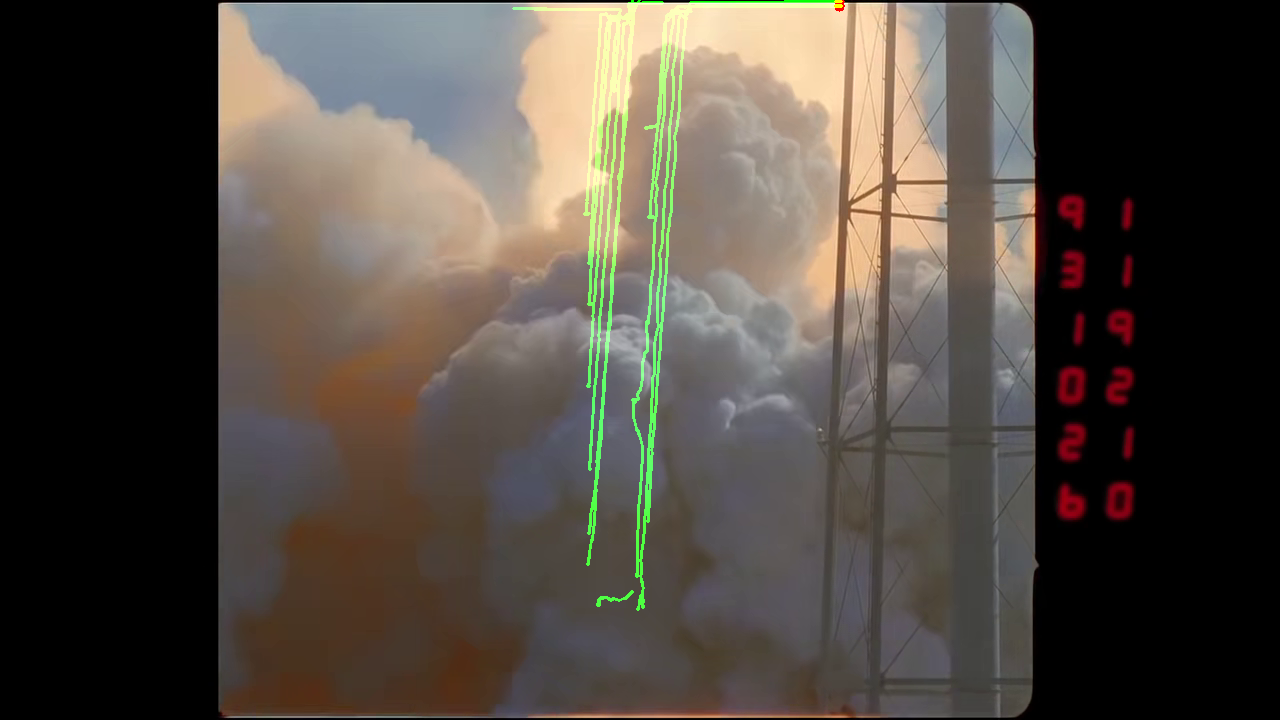

In [8]:
imgs, points, statuses = baseLoop(cv2.VideoCapture('shuttle.mp4'))

In [9]:
statuses[0]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=uint8)

In [10]:
from ipywidgets import interact, IntSlider, fixed, Layout

def display_frame(frame_index, frames):
    img = frames[frame_index]
    plt.figure(figsize = (10, 6))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f'Frame {frame_index}')
    plt.axis('off')
    plt.show()

def interactive_frames(frames):
    slider_layout = Layout(width='70%')
    frame_slider = IntSlider(value = 0, 
                             min = 0, 
                             max = len(frames) - 1, 
                             step = 1, 
                             description = "Frame", 
                             layout = slider_layout)
    
    interact(display_frame, frame_index = frame_slider, frames = fixed(frames))

interactive_frames(imgs)

interactive(children=(IntSlider(value=0, description='Frame', layout=Layout(width='70%'), max=358), Output()),…

### Zadanie 3

Dokonaj analizy znalezionych trajektorii i znajdź prędkość _Discovery_.

Wersja minimum: załóż, że pojazd porusza się z lokalnie stałą prędkością.  
Wersja normalna: wykreśl prędkość pojazdu jako funkcję czasu.  
Wersja z plusem: zastosuj odpowiednią filtrację funkcji położenia, by uniezależnić funkcję czasu od szumu.

*Discovery* wraz ze zbiornikami na paliwo i rakietami ma wysokość ok. 56,1 metra ([źródło](https://www.nasa.gov/reference/the-space-shuttle/)). W celu konwersji pikselów na metry wyznaczymy współrzędne y dla najwyższego i najniższego punktu wahadłowca. Następnie policzymy ich odległość wzdłuż osi pionowej i przekonwertujemy na metry.

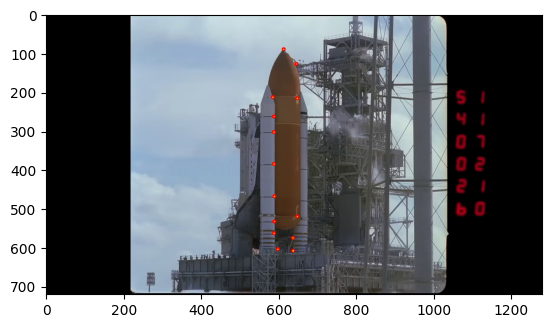

In [11]:
plt.imshow(imgs[0][..., ::-1])

In [95]:
def pixel2world(points: np.ndarray = points[0]):
    SHUTTLE_HEIGHT = 56.1
    
    points = points.reshape(-1, 2)
    y_coords = points[:, 1]
    y_min, y_max = y_coords.min().item(), y_coords.max().item()
    px2world = SHUTTLE_HEIGHT / (y_max - y_min)
    
    return px2world



def update_index(status, idx):
    substatus = status[:idx]
    vanish_occurences = list(substatus).count(0)
    idx = idx - vanish_occurences
    return idx

In [96]:
source = cv2.VideoCapture('shuttle.mp4')
PIXEL2WORLD = pixel2world()
FPS = source.get(cv2.CAP_PROP_FPS)
print(f'Pixel to world ratio: {PIXEL2WORLD} m/px')
print(f'Frames per second: {FPS} fps')

Pixel to world ratio: 0.10830257319126234 m/px
Frames per second: 30.05348189415042 fps


In [124]:
from typing import Literal
from scipy.signal import savgol_filter

def trajectory_stamps(points: list[np.ndarray], 
                      statuses: list[np.ndarray], 
                      idx: int = 10, 
                      method: Literal['x', 'y', 'd'] = 'd',
                      filter: bool = True,
                      window_length: int = 9,
                      polyorder: int = 2):
    coords_list = []
    
    for _, (point, status) in enumerate(zip(points, statuses)):
        idx = update_index(status, idx)
        if idx < 0:
            break
        else:
            x_bottom, y_bottom = point.reshape(-1, 2)[idx]
            coords_list.append((x_bottom, y_bottom))
        
    def get_distance_and_time_stamps(coords_list: list[tuple[float, float]], total_d: list[int]):
        
        if filter:
            coords_array = np.array(coords_list)
            smoothed_x = savgol_filter(coords_array[:, 0], 
                                       window_length = window_length, 
                                       polyorder = polyorder)
            smoothed_y = savgol_filter(coords_array[:, 1], 
                                       window_length = window_length, 
                                       polyorder = polyorder)
            coords_list = list(zip(smoothed_x, smoothed_y))
        
        for coord_prev, coord_next in zip(coords_list[:-1], coords_list[1:]):
        
            if coord_next[1] < 10:
                break
            
            if method == 'x':
                d = np.abs(coord_next[0] - coord_prev[0])
            elif method == 'y':
                d = np.abs(coord_next[1] - coord_prev[1])
            else:
                d = np.sqrt((coord_next[0] - coord_prev[0])**2 + (coord_next[1] - coord_prev[1])**2)
            total_d.append(total_d[-1] + d * PIXEL2WORLD)
        return total_d
    
    total_d = [0]
    total_d = get_distance_and_time_stamps(coords_list, total_d)
    total_time = [i * (1 / FPS) for i in range(len(total_d))]
    
    return total_time, total_d



def count_velocity(total_time: list[float], total_d: list[float]):
    velocity = [0]
    for i, (d_next, d_prev) in enumerate(zip(total_d[1:], total_d[:-1])):
        v = (d_next - d_prev) / (total_time[1:][i] - total_time[:-1][i])
        velocity.append(v)
    return velocity

In [125]:
def distance_plot(axs, total_time, total_d):
    axs.plot(total_time, total_d, label = 'Top point', color = 'red')
    axs.set_xlabel('Time [s]', fontsize = 12)
    axs.set_ylabel('Distance [m]', fontsize = 12)
    axs.set_title('Shuttle trajectory', fontsize = 20)
    axs.legend()
    

def velocity_plot(axs, total_time, total_v):
    axs.plot(total_time, total_v, label = 'Top point', color = 'green')
    axs.set_xlabel('Time [s]', fontsize = 12)
    axs.set_ylabel('Velocity [m/s]', fontsize = 12)
    axs.set_title('Shuttle velocity', fontsize = 20)
    axs.legend()


def acceleration_plot(axs, total_time, total_a):
    axs.plot(total_time, total_a, label = 'Top point', color = 'blue')
    axs.set_xlabel('Time [s]', fontsize = 12)
    axs.set_ylabel(f'Acceleration [$m/s^2$]', fontsize = 12)
    axs.set_title('Shuttle acceleration', fontsize = 20)
    axs.legend()


def plot_dva(total_time, total_d, total_v, total_a):
    fig, axs = plt.subplots(3, 1, figsize = (20, 15))
    distance_plot(axs[0], total_time, total_d)
    velocity_plot(axs[1], total_time, total_v)
    acceleration_plot(axs[2], total_time, total_a)
    for ax in axs:
        ax.label_outer()
    plt.tight_layout()
    plt.show()

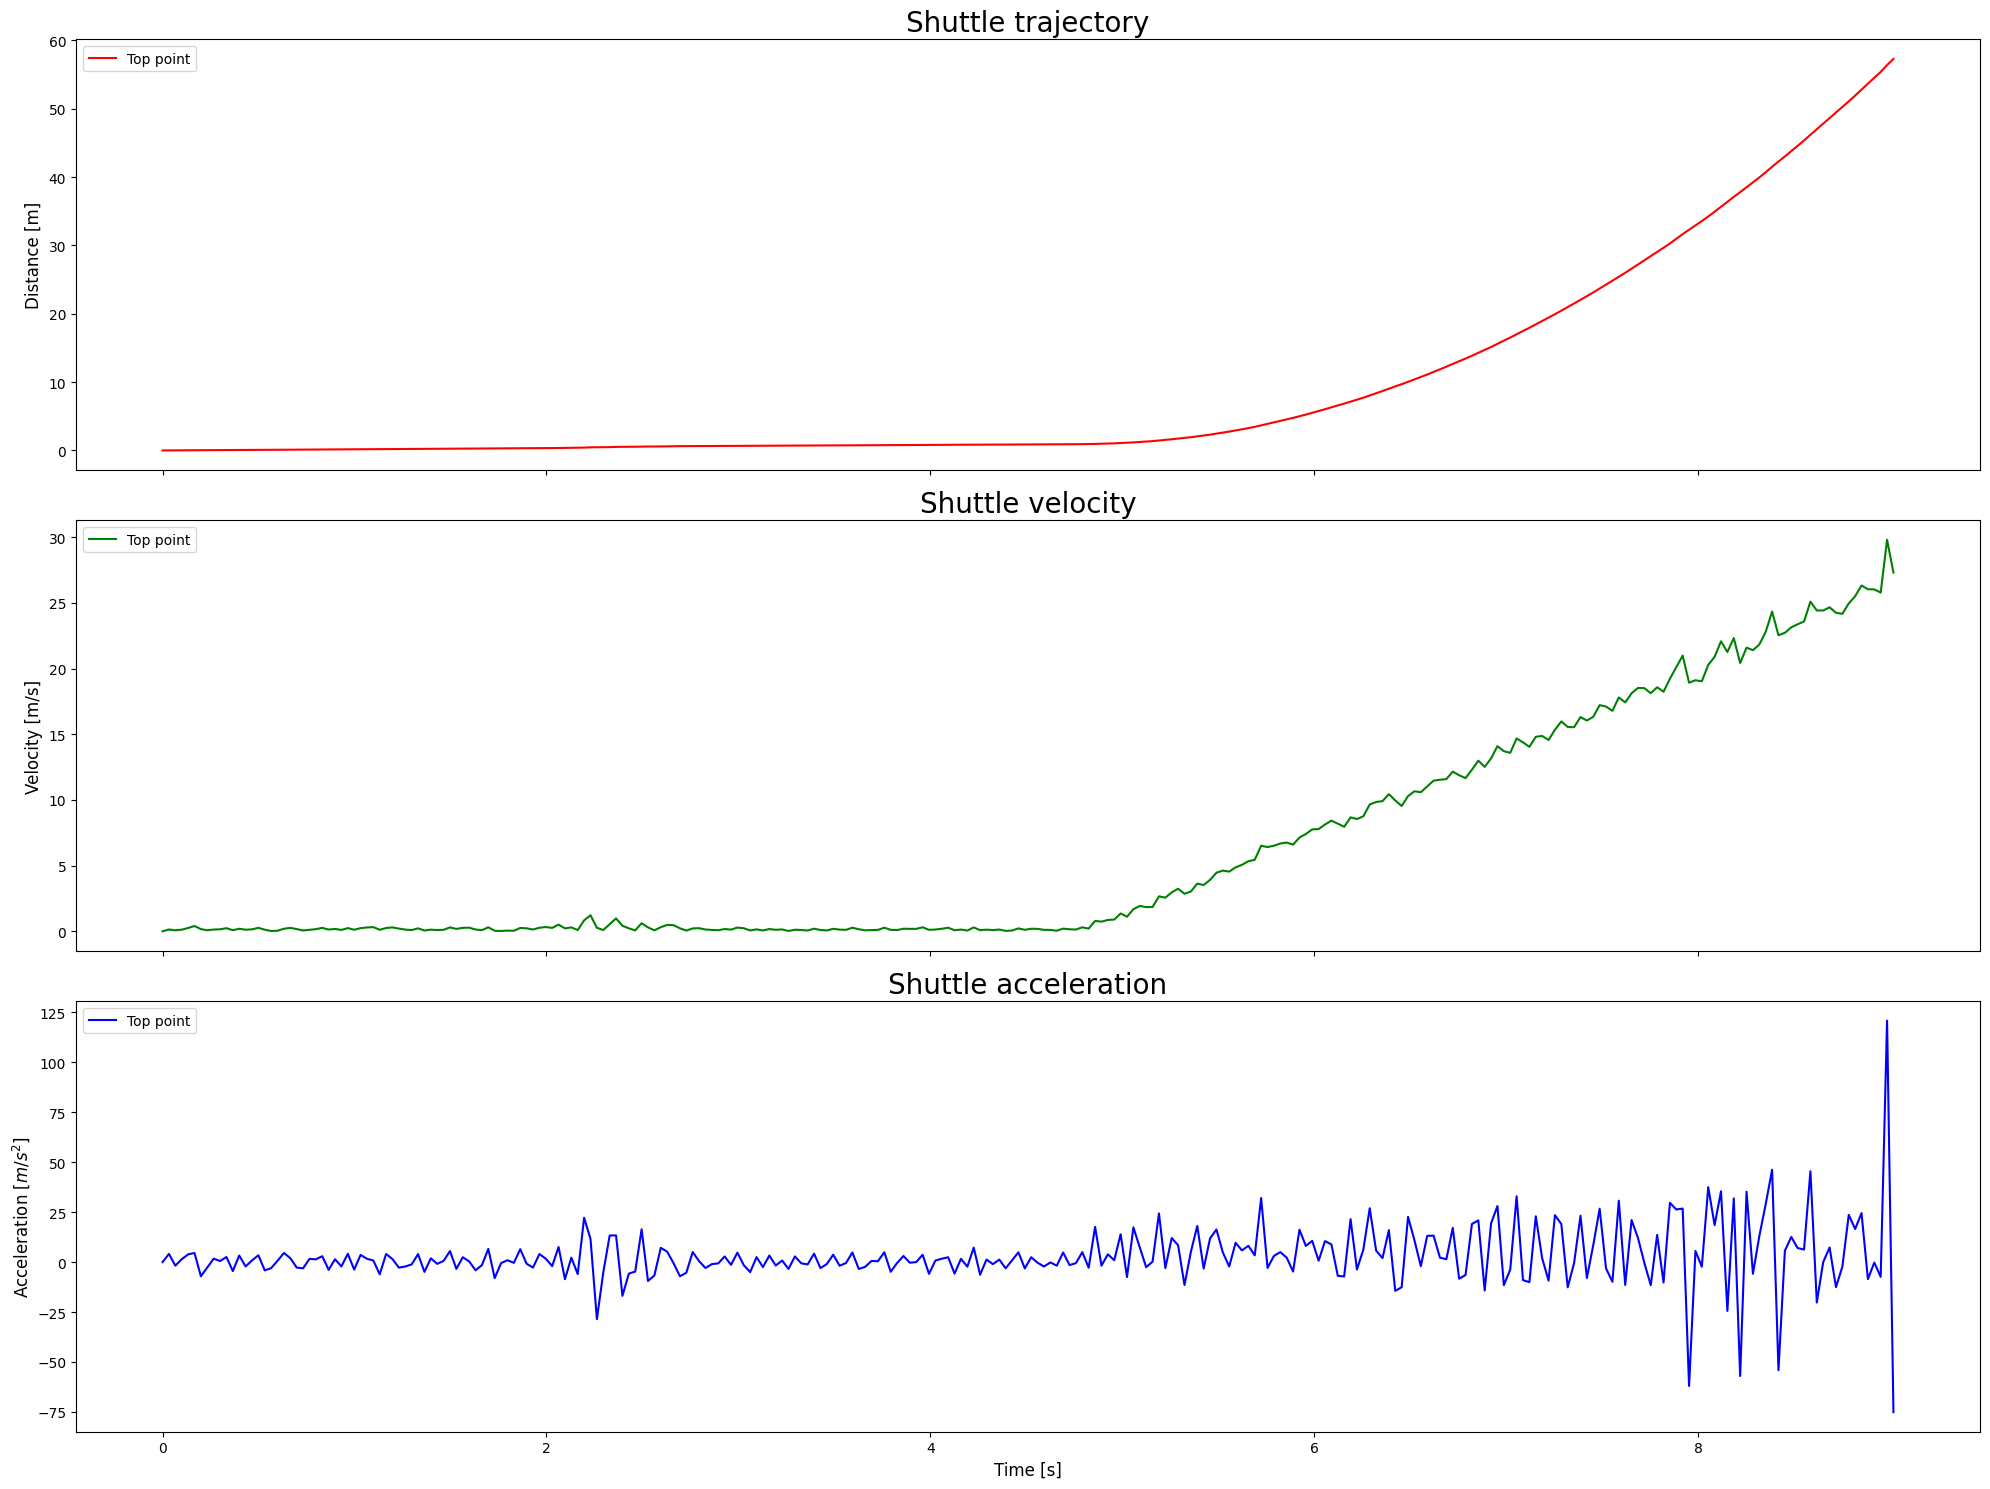

In [129]:
total_time, total_d = trajectory_stamps(points, statuses, idx = 5, method = 'd', window_length = 7)
total_v = count_velocity(total_time, total_d)
total_a = count_velocity(total_time, total_v)

plot_dva(total_time, total_d, total_v, total_a)

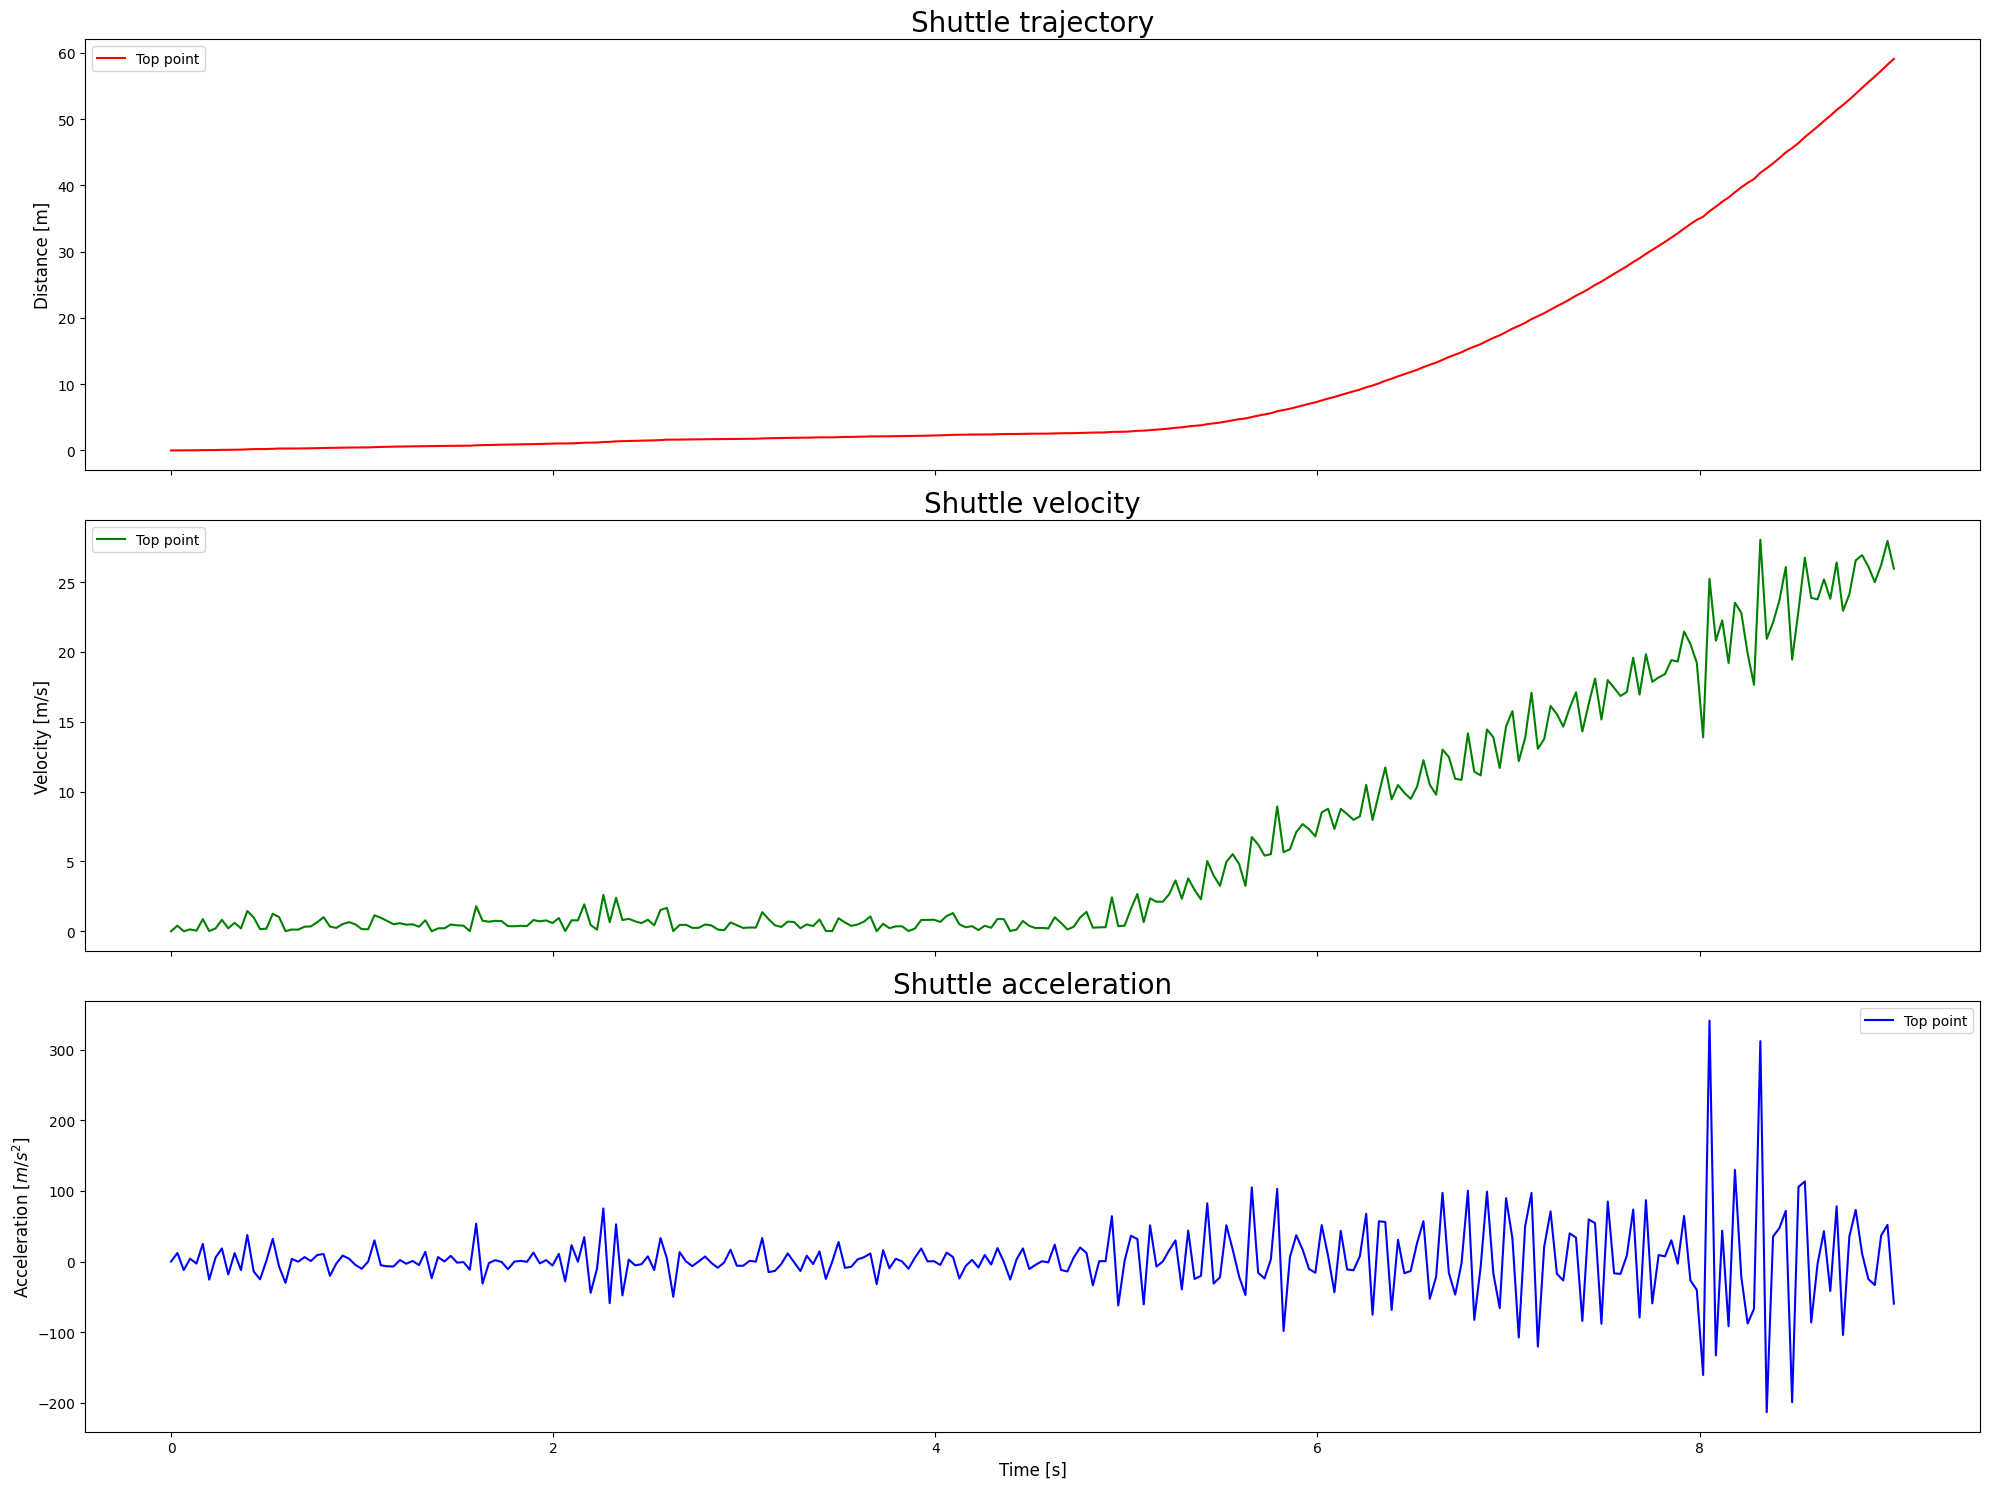

In [127]:
total_time, total_d = trajectory_stamps(points, statuses, idx = 5, method = 'd', filter = False)
total_v = count_velocity(total_time, total_d)
total_a = count_velocity(total_time, total_v)

plot_dva(total_time, total_d, total_v, total_a)